In [1]:
import numpy as np
import os   # 운영체제와 상호작용하기 위한 모듈
from dotenv import load_dotenv

# 환경 변수 로드
load_dotenv()
base_dir = os.getenv('BASE_DIR')

In [2]:
new_data = np.concatenate([
    np.load(os.path.join(base_dir, f'seq_data/seq_npy_1727279424_20_10.npy')),
    np.load(os.path.join(base_dir, f'seq_data/seq_npy_flip_1727279424_20_10.npy')),
    np.load(os.path.join(base_dir, f'seq_data/seq_npy_shift_1727279424_20_10.npy')),
    np.load(os.path.join(base_dir, f'seq_data/seq_npy_flip_shift_1727279425_20_10.npy')),
], axis=0)

print(new_data.shape)
# (데이터의 개수, 프레임 사이즈, 한 프레임당 데이터 개수)

(6036, 20, 235)


In [3]:
from setting import actions
from keras.utils import to_categorical

# 데이터 분리 및 전처리
new_x = new_data[:, :, :-1]    # 시퀀스의 마지막 요소 제외한 모든 값 가져와 할당
new_labels = new_data[:, 0, -1]     # 마지막 요소는 레이블 값

# 원-핫 인코딩으로 변환
new_y = to_categorical(new_labels, num_classes=len(actions))

print(new_x.shape)
print(new_labels.shape)
print(new_y.shape)         # y_data 형태 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...]
print(np.unique(new_labels))    # 레이블 값 출력


(6036, 20, 234)
(6036,)
(6036, 20)
[10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]


In [4]:
from sklearn.model_selection import train_test_split

# 데이터셋 분할 (학습 데이터와 검증 데이터만 사용)
new_x_train, new_x_val, new_y_train, new_y_val = train_test_split(new_x, new_y, test_size=0.2, random_state=2002, stratify=new_labels)

print(new_x_train.shape, new_y_train.shape)
print(new_x_val.shape, new_y_val.shape)

(4828, 20, 234) (4828, 20)
(1208, 20, 234) (1208, 20)


In [5]:
from keras.models import load_model
from keras.layers import Dense

# 기존 모델 로드
model = load_model('models/model_10words_100.keras')

# 마지막 레이어 제거
model.pop()

# 새로운 Dense 레이어 추가
new_output_layer = Dense(20, activation='softmax')

# 모델에 새로운 출력층 추가
model.add(new_output_layer)

# 새 레이블 데이터로 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# 모델 추가 학습
history = model.fit(
    new_x_train, new_y_train,
    validation_data=(new_x_val, new_y_val),
    epochs=100,
    batch_size=32,
    callbacks=[
        ModelCheckpoint('models/model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto'),
        # EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True),
    ]
)

Epoch 1/100


150/151 [============================>.] - ETA: 0s - loss: 0.7849 - accuracy: 0.7604
Epoch 1: val_loss improved from inf to 0.26979, saving model to models\model.keras
151/151 [==============================] - 7s 31ms/step - loss: 0.7824 - accuracy: 0.7612 - val_loss: 0.2698 - val_accuracy: 0.9156 - lr: 0.0010
Epoch 2/100
150/151 [============================>.] - ETA: 0s - loss: 0.2160 - accuracy: 0.9310
Epoch 2: val_loss improved from 0.26979 to 0.15357, saving model to models\model.keras
151/151 [==============================] - 6s 37ms/step - loss: 0.2159 - accuracy: 0.9310 - val_loss: 0.1536 - val_accuracy: 0.9462 - lr: 0.0010
Epoch 3/100
150/151 [============================>.] - ETA: 0s - loss: 0.1985 - accuracy: 0.9371
Epoch 3: val_loss improved from 0.15357 to 0.13202, saving model to models\model.keras
151/151 [==============================] - 9s 58ms/step - loss: 0.1978 - accuracy: 0.9372 - val_loss: 0.1320 - val_accuracy: 0.9561 - lr: 0.0010
Epoch 4/100
151

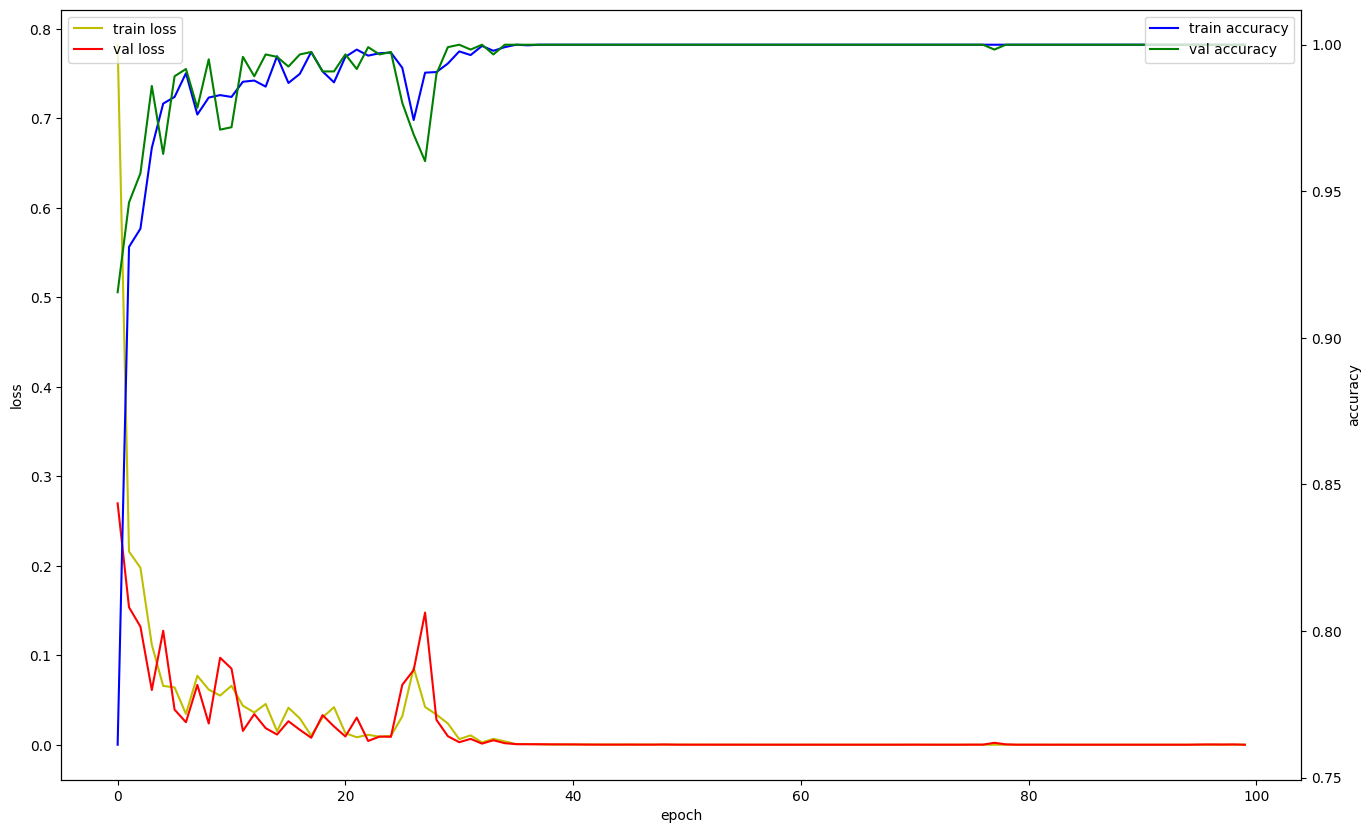

In [7]:
import matplotlib.pyplot as plt

# 학습 데이터/검증 데이터 정확도/손실 그래프
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()